# Домашнее задание к занятию «Тематическое моделирование»
# Нетология | 2024г. | Дубовик А.В.|

____

## Цель:
Обобщить и научиться применять полученные знания в NLP для решения задач классификации текста

## Задание: Классифицировать по тональности отзывы на банки с сайта banki.ru
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5
### 1. Анализ текста
    1.1. Посчитайте количество отзывов в разных городах и на разные банки
    1.2. Постройте гистограмы длин слов в символах и в словах
    1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных
    1.4. Постройте кривые Ципфа и Хипса
    1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и "доверие"?
    1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)
### 2. Тематическое моделирование
    2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем
    2.2. Приведите примеры понятных (интерпретируемых) тем
    2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать объяснить?
### 3. Классификация текстов
Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)

    3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое
    3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
    3.3. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
    3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
        1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)
        2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
    3.5. Используйте accuracy и F-measure для оценки качества классификации.

<b> Результат:</b>
* Ноутбук с обученной моделью, где показаны результаты метрик качества: accuracy и f1-score

<b>Инструменты:</b> 
* Ноутбук
* Подробное описание домашнего задания - здесь заменю ссылку на гитхаб
* Jupyter notebook, Python, nltk, gensim, sklearn

____

## Решение:

### Импорт библиотек, подготовка данных

#### Импорт библиотек:

In [4]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
from collections import Counter

In [5]:
import pandas as pd
import numpy as np
import nltk
from string import punctuation
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
%matplotlib inline
# %pylab inline

#### Загрузка и подготовка данных:

In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:50, 4000.39it/s]


Посмотрим на пример отзыва:

In [7]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [8]:
data = pd.DataFrame(responses)

In [9]:
data.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [11]:
# сначала посмотрим на кол-во уникальных городов и банков
data['city'].nunique(), data['bank_name'].nunique()

(5823, 670)

In [12]:
data.city.value_counts()

city
г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: count, Length: 5823, dtype: int64

In [13]:
data.bank_name.value_counts()

bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: count, Length: 670, dtype: int64

Достаем все названия городов из полного микса. Приводим все названия городов в русский язык, убираем лишнее, если совсем не получиться достать название города

In [14]:
# 1. после исследования обнаружилось что часто области находятся в скобках, их проще всего удалить используя регулярку

data['city'] = data['city'].str.replace('\(.*?\)', '', regex=True)

In [15]:
data.city.value_counts()

city
г. Москва                                    55354
г. Санкт-Петербург                           14342
г. Екатеринбург                               2337
г. Новосибирск                                2300
г. Нижний Новгород                            1976
                                             ...  
г. Еланский район                                1
г. ВОЛГОГРАДСКАЯ ОБЛАСТЬ ОЛЬХОВСКИЙ РАЙОН        1
г. село Актаныш                                  1
г. Бугуруслан                                    1
г. Краснодарский край, ст.Павловская             1
Name: count, Length: 5426, dtype: int64

In [16]:
def clean_text(text):
    # Преобразование текста к нижнему регистру
    text = text.lower()
    # Удаление точек и запятых, а так же букв г перед городами
    text = text.replace('г.', '').replace(',', '')
    # Удаление лишних пробелов и знаков препинания
    text = ' '.join(text.split())
    
    return text

In [17]:
data['city'] = data['city'].apply(lambda x: clean_text(str(x)))

In [18]:
data.city.value_counts()

city
москва                              56907
none                                15174
санкт-петербург                     14698
новосибирск                          2389
екатеринбург                         2387
                                    ...  
краснодар-сочи                          1
мамоново                                1
ростов ярославский                      1
р.п. тамала пензенская область          1
краснодарский край ст.павловская        1
Name: count, Length: 4125, dtype: int64

In [19]:
data.head(13)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
5,москва,False,Не тут-то было...,0,лицензия № 606,bankir76,Гагаринский,2015-06-05 11:37:31,"Я, как и многие вкладчики открыл на 1000 руб. ...",NaN
6,волгоград,False,Получение УЭК,0,лицензия № 1481,N0mikom,Сбербанк России,2015-06-05 11:57:51,Здравствуйте! Подал заявление на получение УЭ...,NaN
7,москва,False,Вот так поворот!,0,лицензия № 2673,Altairseg,Тинькофф Банк,2015-06-05 11:59:01,Был крайне удивлён новостью от 27/28 мая - об ...,NaN
8,пермь,False,О разглашении персональных данных,0,лицензия № 1460,svetlana198,Восточный Экспресс Банк,2015-06-05 12:08:21,Сотрудники банка Восточный систематически сооб...,NaN
9,ростов-на-дону,False,Прошу о помощи,2,лицензия № 1623,Daria88,ВТБ 24,2015-06-05 12:18:22,Добрый день! Являюсь заемщиком в Банке ВТБ 24....,NaN


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                153499 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [21]:
# посмотрим сколько всего записей городов встречается 1 раз - скорее всего это ошибки так как в колонке много мусора

len(data['city'].value_counts()[data['city'].value_counts() == 1])

2777

In [22]:
# Будем считать, что это мусор и удалим эти строки

data = data[~data['city'].isin(data['city'].value_counts()[data['city'].value_counts() == 1].index)]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150722 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                150722 non-null  object 
 1   rating_not_checked  150722 non-null  bool   
 2   title               150722 non-null  object 
 3   num_comments        150722 non-null  int64  
 4   bank_license        150721 non-null  object 
 5   author              150702 non-null  object 
 6   bank_name           150722 non-null  object 
 7   datetime            150722 non-null  object 
 8   text                150722 non-null  object 
 9   rating_grade        87220 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 11.6+ MB


In [24]:
data[data['city'] == "none"]

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
89526,none,False,"Халатность сотрудника, обман потребителя",3,лицензия № 1481,марс13,Сбербанк России,2013-03-06 10:26:00,В январе мной было подано заявление на досрочн...,1.0
131055,none,False,"Любимый мой банк, но в последнее время удивляет",7,лицензия № 3279,Lzt06,Национальный Банк «Траст»,2010-09-13 21:34:00,"С удовольствием обслуживаюсь с 2009 г. в НБ ""Т...",3.0
138284,none,False,Из-за одного некомпетентного сотрудника портит...,5,лицензия № 1460,1й2ц3у4,Восточный Экспресс Банк,2009-07-03 01:06:00,Как один человек может испортить репутацию бан...,NaN
138285,none,False,Хамство кассира в отделении на Автозаводской,7,лицензия № 2771,sergor,Юниаструм Банк,2009-07-01 18:39:00,"Недавно был в отделении на Автозаводской, Моск...",1.0
138286,none,False,МЕП,61,лицензия № 2557,Квинки,Ситибанк,2009-06-29 16:42:00,"Это, собственно, не отзыв, это - размышлизм......",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,none,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,none,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,none,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,none,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


Так как в данных по городам и банкам могут быть none, то я решил сделать новый df без них :), так как смысла в них уже не будет.

In [25]:
# данные по городам без none, понятно что опять теряю данные, но это лучше чем они совсем никому не нужны, и это только для этой ДЗ
df_clean = data[data['city'] != "none"]

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135548 entries, 0 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                135548 non-null  object 
 1   rating_not_checked  135548 non-null  bool   
 2   title               135548 non-null  object 
 3   num_comments        135548 non-null  int64  
 4   bank_license        135547 non-null  object 
 5   author              135547 non-null  object 
 6   bank_name           135548 non-null  object 
 7   datetime            135548 non-null  object 
 8   text                135548 non-null  object 
 9   rating_grade        73272 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.5+ MB


In [27]:
(data.city.count() - df_clean.city.count())/data.city.count() 

0.100675415665928

> Я сделал первую часть по очистке данных, потеряли примерно 10% данных, я думаю это терпимо. Далее приступаем к самим заданиям

### 1. Анализ текста

#### 1.1. Посчитайте количество отзывов в разных городах и на разные банки


In [28]:
df_clean.bank_name.value_counts()

bank_name
Сбербанк России              24636
Альфа-Банк                    8932
ВТБ 24                        7194
Хоум Кредит Банк              7191
Русский Стандарт              7110
                             ...  
Русский Финансовый Альянс        1
Дойче Банк                       1
Банк Премьер Кредит              1
Кубаньторгбанк                   1
Нижегородпромстройбанк           1
Name: count, Length: 592, dtype: int64

In [29]:
df_clean.city.value_counts()

city
москва                     56907
санкт-петербург            14698
новосибирск                 2389
екатеринбург                2387
нижний новгород             2049
                           ...  
москоу                         2
магас                          2
пушкино мо                     2
дальнегорск                    2
кемерово / екатеринбург        2
Name: count, Length: 1347, dtype: int64

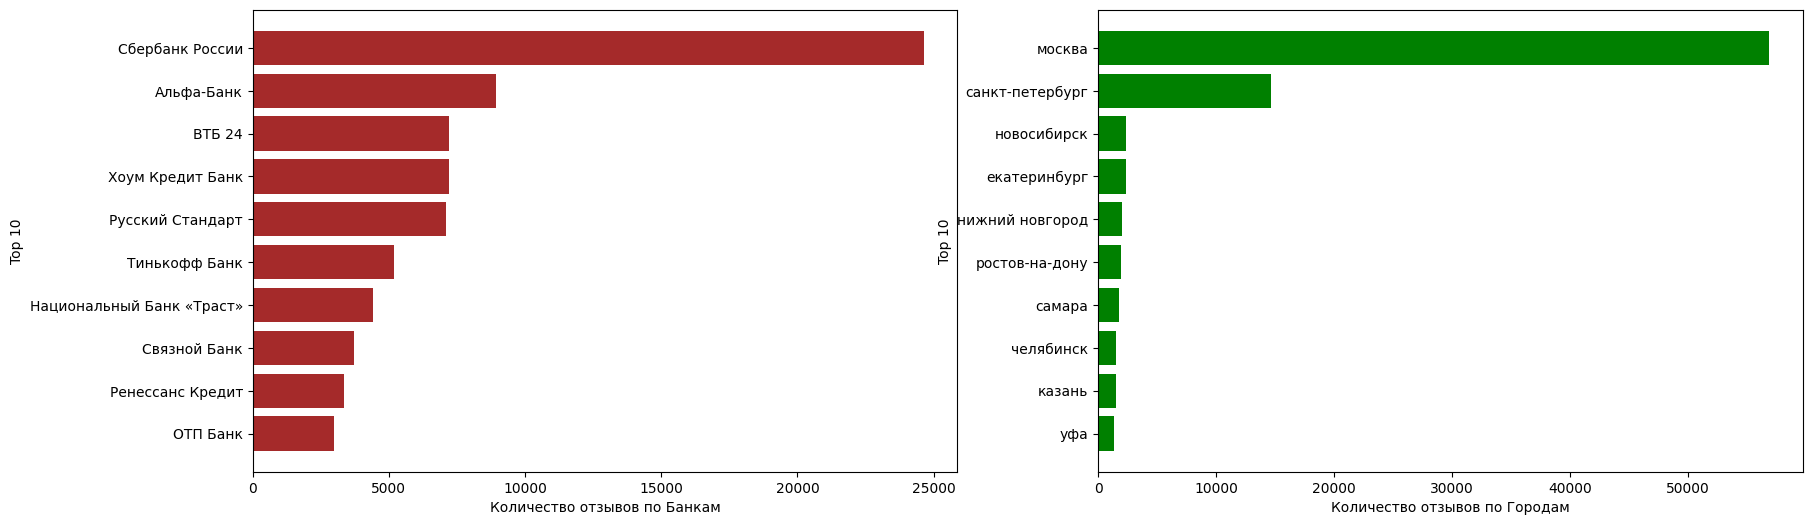

In [30]:
# Данные по городам и банкам
banks = df_clean.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(10)
cities = df_clean.groupby(['city']).count()['text'].sort_values(ascending=False).head(10)

# Размер фигуры
plt.figure(figsize=(20, 6))

# Создание первого подграфика
plt.subplot(1, 2, 1)
plt.barh(banks.index[::-1], banks.values[::-1], color='brown')
plt.xlabel('Количество отзывов по Банкам')
plt.ylabel('Top 10')

# Создание второго подграфика
plt.subplot(1, 2, 2)
plt.barh(cities.index[::-1], cities.values[::-1], color='green')
plt.xlabel('Количество отзывов по Городам')
plt.ylabel('Top 10')

# Показать графики
plt.show()

In [31]:
# Видно, что можно было бы еще почистить данные, но будем считать, что эти отклонения не значительные

#### 1.2. Постройте гистограмы длин слов в символах и в словах


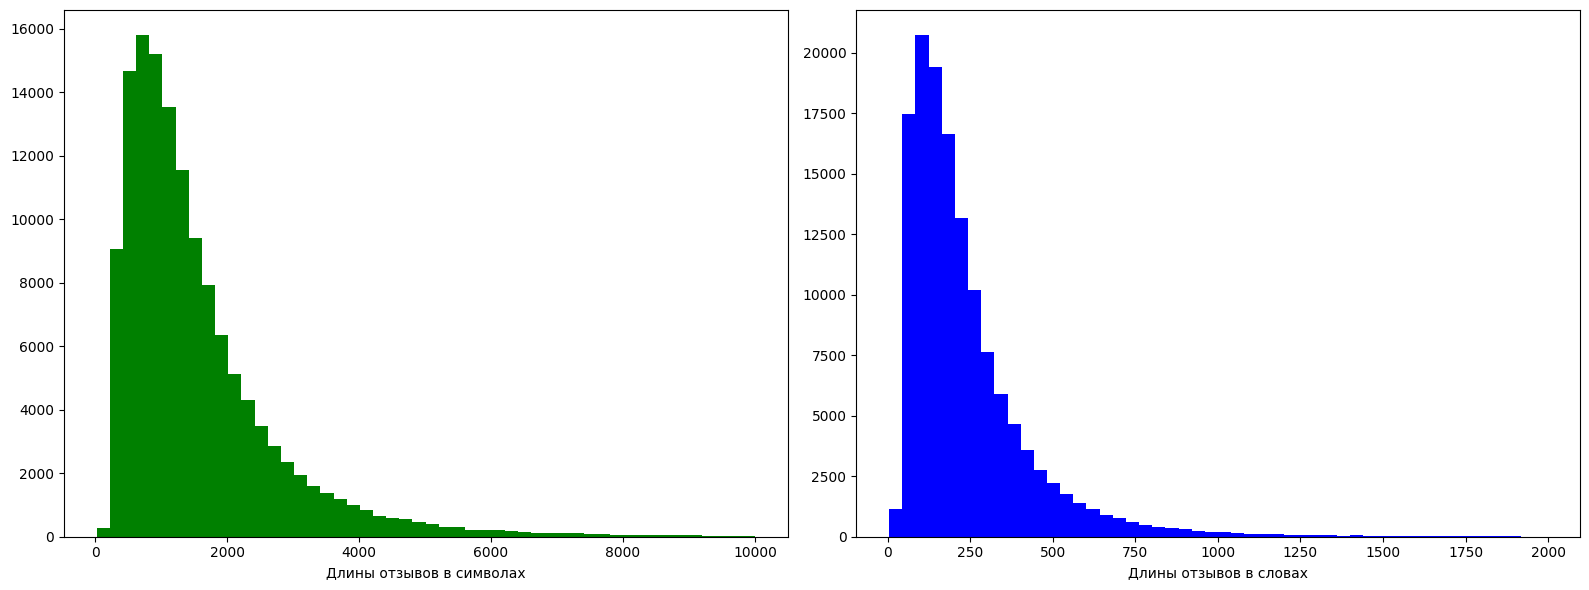

In [32]:
# Установка размера фигуры
plt.rcParams['figure.figsize'] = [16, 6]

# Создание фигуры и осей
fig, axes = plt.subplots(1, 2)

# Построение первой гистограммы
len_c = df_clean.text.apply(len)
len_c[len_c < 10000].plot(kind = 'hist', bins = 50, ax = axes[0], color = 'green')
axes[0].set_xlabel('Длины отзывов в символах')
axes[0].set_ylabel('')

# Построение второй гистограммы
len_t = df_clean.text.str.split().apply(len)
len_t[len_t < 2000].plot(kind = 'hist', bins = 50, ax = axes[1], color = 'blue')
axes[1].set_xlabel('Длины отзывов в словах')
axes[1].set_ylabel('')

# Отображение фигуры
plt.tight_layout()
plt.show()

##### 1.3. Найдите 10 самых частых:

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
# Описание и что делает функция, что бы потом не забыть зачем я все это сделал :) я использовал phind.com 
# он помогает мне иногда разобраться в коде, а так же использую его для решения рабочих задач

from collections import Counter
from tqdm import tqdm
from string import punctuation

def process_tokens(df, column_name, save_all_tokens=False, top_n = 10):
    """
    Обрабатывает токены из указанного столбца DataFrame, подсчитывает количество уникальных токенов и их суммарное количество.
    Исключает токены, состоящие из пунктуации.
    Возвращает счетчик токенов, список количества уникальных токенов, список суммарного количества токенов и, при необходимости, список всех токенов.
    Также позволяет выбрать количество самых частых токенов для вывода.

    :param df: DataFrame, содержащий данные для обработки.
    :param column_name: Имя столбца DataFrame, из которого извлекаются токены.
    :param save_all_tokens: Булево значение, указывающее, нужно ли сохранять все токены в список.
    :param top_n: Количество самых частых токенов для вывода.
    :return: Счетчик токенов, список количества уникальных токенов, список суммарного количества токенов и, при необходимости, список всех токенов.
    """
    
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens_all = [] if save_all_tokens else None

    for index, row in tqdm(df.iterrows(), total=len(df)):
        tokens = row[column_name].split()
        # Исключение токенов, состоящих из пунктуации
        tokens = [token for token in tokens if token not in punctuation]
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(sum(cnt.values()))
        if save_all_tokens:
            tokens_all += tokens

    # # Вывод top_n самых частых токенов
    # top_tokens = cnt.most_common(top_n)
    # print(top_tokens)

    if save_all_tokens:
        return cnt, n_types, n_tokens, tokens_all
    else:
        return cnt, n_types, n_tokens

***a. Топ 10 слов:***

In [35]:
# оставляем только Текст из букв крилициы
ru_words = re.compile("[А-Яа-я]+") 

# оставляем только слова из текста
def words_only(text):
    try:
        return " ".join(ru_words.findall(text))
    except:
        return ""

In [36]:
df = df_clean.copy()
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [37]:
cnt_w, n_types_w, n_tokens_w = process_tokens(df, 'text_tokinized')

100%|██████████| 135548/135548 [03:34<00:00, 632.61it/s]


In [38]:
# Вывод:
total_tokens_w = sum(cnt_w.values())
print(f"Общее количество всех токенов: {total_tokens_w}")
print(f"Топ 10 слов: {cnt_w.most_common(10)}")

Общее количество всех токенов: 31616907
Топ 10 слов: [('в', 1187443), ('и', 943581), ('не', 765493), ('на', 632460), ('что', 572561), ('я', 518466), ('с', 416052), ('по', 336252), ('мне', 289281), ('банка', 250945)]


***b. Топ 10 слов без стоп-слов:***

In [39]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Создание списка стоп-слов
mystopwords = stopwords.words('russian') + list(punctuation) + [
        '``','\'\'', '...'] + [
        'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г',
        'который','прошлый','сей', 'свой', 'наши', 'мочь', 'такой', 
        'в', 'и','не', 'на', 'что', 'я', 'с', 'по', 'мне', 'мой', 'вс', 'л', 'тот', 'м', 'ещ'
        ]

In [41]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [42]:
df['text_tokinized_stw'] = df.text_tokinized.str.lower().apply(remove_stopwords)

In [43]:
cnt_stw, n_types_stw, n_tokens_stw, tokens_all_stw = process_tokens(df, 'text_tokinized_stw', save_all_tokens = True)

100%|██████████| 135548/135548 [03:29<00:00, 648.48it/s]


In [44]:
# Вывод:
total_tokens_stw = sum(cnt_stw.values())
print(f"Общее количество всех токенов: {total_tokens_stw}")
print(f"Топ 10 слов без стоп-слов: {cnt_stw.most_common(10)}")

Общее количество всех токенов: 19482333
Топ 10 слов без стоп-слов: [('банка', 250945), ('банк', 194603), ('деньги', 117316), ('карту', 96097), ('карты', 93731), ('кредит', 71096), ('день', 69090), ('заявление', 64555), ('банке', 64225), ('отделение', 59648)]


***c. Топ 10 лемм:***

In [45]:
# pip install pymystem3

In [46]:
from pymystem3 import Mystem

In [47]:
m = Mystem()

def lemmatize(text, m = Mystem()):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [48]:
df['text_lemmatize'] = df['text_tokinized_stw'].apply(lemmatize)

In [49]:
cnt_tl, n_types_tl, n_tokens_tl, tokens_all_tl = process_tokens(df, 'text_lemmatize', save_all_tokens = True)

100%|██████████| 135548/135548 [01:17<00:00, 1738.13it/s]


In [50]:
# Вывод:
total_tokens_tl = sum(cnt_tl.values())
print(f"Общее количество всех токенов: {total_tokens_tl}")
print(f"Топ 10 лемм: {cnt_tl.most_common(10)}")

Общее количество всех токенов: 19482333
Топ 10 лемм: [('банк', 562366), ('карта', 305626), ('деньги', 160465), ('день', 155447), ('мой', 148867), ('кредит', 137838), ('отделение', 127846), ('сотрудник', 122960), ('клиент', 122037), ('счет', 113075)]


***d. существительных***

In [51]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()


In [52]:
def find_nouns(text, m = morph):
    
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []

In [53]:
find_nouns(df.text_lemmatize.iloc[1])

'день держатель карта сбербанк россия год фамилия банк документ копия паспорт свидетельство брак карта фамилия муж токарева мария александровна секлетина необходимость услуга сбербанк страница карта специалист отделение сбербанк база банк фамилия секлетина скан документ контакт звонок ч время ситуация база секлетина карта фамилия токарева связь истечение срок обслуживание документ копия паспорт свидетельство брак результат ноль ситуация уважение токарев мария александровна'

In [54]:
from multiprocessing import Pool

# Импортируем класс Pool из модуля multiprocessing для создания пула процессов
with Pool() as p:
    # Применяем функцию to_nouns к каждому элементу столбца 'lemma' DataFrame df
    # в параллельном режиме, используя все доступные процессоры.
    # Результаты сохраняются в новом столбце 'nouns' DataFrame df.
    df['text_nouns'] = p.map(find_nouns, df.text_lemmatize)

In [55]:
cnt_tn, n_types_tn, n_tokens_tn, tokens_all_tn = process_tokens(df, 'text_nouns', save_all_tokens = True)

100%|██████████| 135548/135548 [00:43<00:00, 3101.76it/s]


In [90]:
# Вывод:
total_tokens_tn = sum(cnt_tn.values())
print(f"Общее количество всех токенов: {total_tokens_tn}")
print(f"Топ 10 существительных: {cnt_tn.most_common(10)}")

Общее количество всех токенов: 9563408
Топ 10 существительных: [('банк', 562366), ('карта', 305626), ('деньги', 160465), ('день', 155447), ('кредит', 137838), ('отделение', 127846), ('сотрудник', 122960), ('клиент', 122037), ('счет', 113075), ('сумма', 100918)]


#### 1.4. Постройте кривые Ципфа и Хипса

***a. Кривая Ципфа***

Закономерность: если все слова корпуса текста упорядочить по убыванию частоты
их использования, то частота n-го слова обратно пропорциональна его порядковому
номеру n.
Иными словами, частотность слов убывает очень быстро

| дисклеймер: данные не из исходной таблицы, а из слов без стоп-слов |

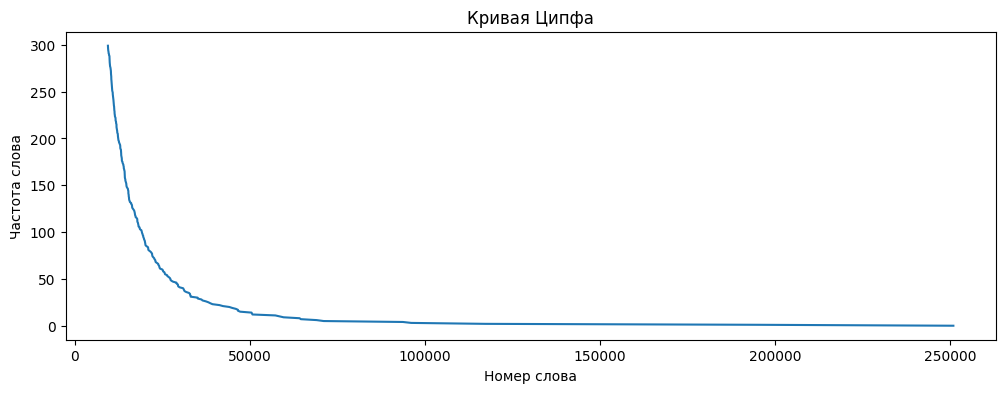

In [57]:
freqs = list(cnt_stw.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()

***b. Кривая Хипса***

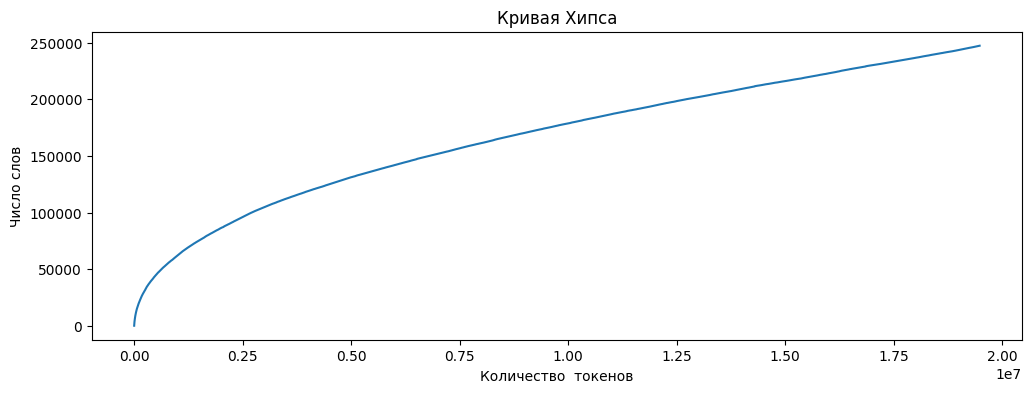

In [58]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens_stw, n_types_stw)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.show()

#### 1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и "доверие"?

***a. Какое слово встречается чаще, "сотрудник" или "клиент"***

In [59]:
# Так как сотрудник и клиент существительное, то берем последние данные (существительные)

from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all_tn)

In [60]:
# сравниваем какое слово встречается чаще
compare_and_print_key = lambda x, y: print(f"{x} встречается чаще" if Freq_Dist['сотрудник'] > Freq_Dist['клиент'] else f"{y} встречается чаще" if Freq_Dist['клиент'] > Freq_Dist['сотрудник'] else "Оба слова встречаются одинаково")

# запускаем лямбду
compare_and_print_key('Сотрудник', 'Клиент')

Сотрудник встречается чаще


***b. Cколько раз встречается слова "мошенничество" и "доверие"***

In [61]:
count_1 = Freq_Dist['мошенничество']
count_2 = Freq_Dist['доверие']

In [62]:
print(f'Слово "мошенничество" встречается - {count_1} раз')
print(f'Слово "доверие" встречается - {count_2} раз')

Слово "мошенничество" встречается - 3048 раз
Слово "доверие" встречается - 1889 раз


#### 1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

In [64]:
df['rating_grade'].value_counts()

rating_grade
1.0    39054
2.0    13020
5.0    10314
3.0     7385
4.0     3499
Name: count, dtype: int64

In [65]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stw,text_lemmatize,text_nouns
0,москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...,день клиент банк поручитель договор лицо отнош...
1,новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...,день держатель карта сбербанк россия год фамил...
2,москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...,заявление карта покупка интернет магазин сумма...


Попробуем сбалансировать выборки. 
Выборка выполняется случайным образом, что позволяет получить представление о распределении оценок в исходном наборе данных, не затрагивая его полностью.

In [66]:
# Получаем частоты встречаемости каждого рейтинга
counts = df['rating_grade'].value_counts()

# Извлекаем количество отзывов для рейтингов 1.0 и 5.0
count_1 = counts.get(1.0, 0)
count_5 = counts.get(5.0, 0)

# Сравниваем и выводим минимальное количество отзывов
min_count = min(count_1, count_5)

In [67]:
num = int(min_count)

# Выборка строк с рейтингом 1
df_sample_1 = df[(df.rating_grade == 1)].sample(n = num).copy()

# Выборка строк с рейтингом 5
df_sample_5 = df[(df.rating_grade == 5)].sample(n = num)

# Объединение двух выборок
df_temp = pd.concat([df_sample_1, df_sample_5], ignore_index = True)

# Вывод количества отзывов для каждого рейтинга в объединенном DataFrame
df_temp.rating_grade.value_counts()

rating_grade
1.0    10314
5.0    10314
Name: count, dtype: int64

In [68]:
tokens_by_topic = []

for rating in df_temp.rating_grade.unique():
    tokens = []
    sample = df_temp[df_temp['rating_grade'] == rating]
    
    for i in range(len(sample)):
        tokens += sample.text_lemmatize.iloc[i].split()
        
    tokens_by_topic.append(tokens)

1. Униграммы

In [69]:
# Инициализация объекта TfidfVectorizer с настройками для анализа текста
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #, min_df = 0)

# Преобразование списка токенов в матрицу TF-IDF
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])

In [70]:
# Получение имен признаков (слов) из обученного векторизатора
feature_names = tfidf.get_feature_names_out() 

In [71]:
# Инициализация списков для ранжирования слов по TF-IDF значениям
tfidf_ranging_5 = []
tfidf_ranging_1 = []

# Преобразование матрицы TF-IDF в плотную форму для удобства работы
dense = tfidf_matrix.todense()

# Извлечение и сортировка топ-70 слов по их TF-IDF значениям для первого текста
text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranging_5.append(phrase)
    
# Извлечение и сортировка топ-70 слов по их TF-IDF значениям для второго текста
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranging_1.append(phrase)

In [72]:
# Создание DataFrame из двух списков с именами 'tfidf_ranging_5' и 'tfidf_ranging_1'
df_range = pd.DataFrame({'tfidf_ranging_5': tfidf_ranging_5,'tfidf_ranging_1': tfidf_ranging_1})

In [73]:
df_range.head(10)

,tfidf_ranging_5,tfidf_ranging_1
0,банк,банк
1,карта,карта
2,очень,деньги
3,клиент,день
4,день,мой
5,сотрудник,отделение
6,кредит,сотрудник
7,отделение,кредит
8,вклад,счет
9,мой,клиент


In [74]:
# Создание нового столбца 'tfidf_ranging_5_cleared' в DataFrame 'df_range', 
# который содержит слова из 'tfidf_ranging_5', исключая те, которые присутствуют в 'tfidf_ranging_1'.
# Используется метод isin() для создания булевой маски, указывающей, содержится ли каждое значение из 'tfidf_ranging_5' в 'tfidf_ranging_1'.
# Оператор ~ инвертирует маску, чтобы выбрать только те слова, которых нет в 'tfidf_ranging_1'.
df_range['tfidf_ranging_5_cleared'] = df_range.tfidf_ranging_5[~df_range.tfidf_ranging_5.isin(df_range.tfidf_ranging_1)]

# Аналогично, создается новый столбец 'tfidf_ranging_1_cleared', который содержит слова из 'tfidf_ranging_1', 
# исключая те, которые присутствуют в 'tfidf_ranging_5'. Это делается для того, чтобы получить список слов, уникальных для каждого из текстов, исключая пересечения.
df_range['tfidf_ranging_1_cleared'] = df_range.tfidf_ranging_1[~df_range.tfidf_ranging_1.isin(df_range.tfidf_ranging_5)]

In [75]:
df_range.iloc[:,-2:].dropna()

,tfidf_ranging_5_cleared,tfidf_ranging_1_cleared
30,быстро,договор
38,очередь,отвечать
39,открывать,средство
42,отзыв,рубль
43,первый,говорить
57,процент,срок
61,помогать,давать
63,условие,смс


1. Биграммы

In [76]:
# Инициализация объекта TfidfVectorizer с настройками для анализа текста
tfidf_2n = TfidfVectorizer(analyzer='word', ngram_range=(2,2)) #, min_df = 0)

# Преобразование списка токенов в матрицу TF-IDF
tfidf_matrix_2n = tfidf_2n.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])

In [77]:
# Получение имен признаков (слов) из обученного векторизатора
feature_names_2n = tfidf_2n.get_feature_names_out() 

In [78]:
# Инициализация списков для ранжирования слов по TF-IDF значениям
tfidf_ranging_5_2n = []
tfidf_ranging_1_2n = []

# Преобразование матрицы TF-IDF в плотную форму для удобства работы
dense = tfidf_matrix_2n.todense()

# Извлечение и сортировка топ-70 слов по их TF-IDF значениям для первого текста
text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names_2n[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranging_5_2n.append(phrase)
    
# Извлечение и сортировка топ-70 слов по их TF-IDF значениям для второго текста
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names_2n[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranging_1_2n.append(phrase)

In [79]:
# Создание DataFrame из двух списков с именами 'tfidf_ranging_5' и 'tfidf_ranging_1'
df_range_2n = pd.DataFrame({'tfidf_ranging_5_2n': tfidf_ranging_5_2n,'tfidf_ranging_1_2n': tfidf_ranging_1_2n})

In [80]:
# Создание нового столбца 'tfidf_ranging_5_cleared' в DataFrame 'df_range', 
# который содержит слова из 'tfidf_ranging_5', исключая те, которые присутствуют в 'tfidf_ranging_1'.
# Используется метод isin() для создания булевой маски, указывающей, содержится ли каждое значение из 'tfidf_ranging_5' в 'tfidf_ranging_1'.
# Оператор ~ инвертирует маску, чтобы выбрать только те слова, которых нет в 'tfidf_ranging_1'.
df_range_2n['tfidf_ranging_5_cleared_2n'] = df_range_2n.tfidf_ranging_5_2n[~df_range_2n.tfidf_ranging_5_2n.isin(df_range_2n.tfidf_ranging_1_2n)]

# Аналогично, создается новый столбец 'tfidf_ranging_1_cleared', который содержит слова из 'tfidf_ranging_1', 
# исключая те, которые присутствуют в 'tfidf_ranging_5'. Это делается для того, чтобы получить список слов, уникальных для каждого из текстов, исключая пересечения.
df_range_2n['tfidf_ranging_1_cleared_2n'] = df_range_2n.tfidf_ranging_1_2n[~df_range_2n.tfidf_ranging_1_2n.isin(df_range_2n.tfidf_ranging_5_2n)]

In [81]:
df_range_2n.iloc[:,-2:].dropna()

,tfidf_ranging_5_cleared_2n,tfidf_ranging_1_cleared_2n
21,очень быстро,писать заявление
24,очень довольный,номер телефон
26,работа банк,отделение сбербанк
28,пользоваться услуга,мой карта
30,большой спасибо,деньги счет
33,кредитный лимит,мой заявление
35,услуга банк,погашение кредит
38,качество обслуживание,срок рассмотрение
42,банк год,сайт банк
44,очень приятно,деньги карта


### 2. Тематическое моделирование

#### 2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем


In [82]:
from gensim.corpora import Dictionary

texts = [df['text_lemmatize'].iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

***Latent Dirichlet Allocation (LDA)*** — это метод машинного обучения, используемый для анализа содержания текстовых документов и выявления скрытых тем. LDA предполагает, что каждый документ может быть представлен как смесь нескольких тем, а каждая тема — как смесь нескольких слов. Это позволяет моделировать распределение тем в документах и распределение слов в темах.

In [83]:
from gensim.models import LdaModel

In [84]:
lda_model = LdaModel(corpus = corpus, # мешок слов
                id2word = dictionary, # Словарь, который содержит все уникальные слова в корпусе и их соответствующие ID.
                num_topics = 20,      # Количество тем, которые модель LDA будет искать в данных. В вашем случае, модель будет искать 20 тем.
                alpha = 'auto',       # Параметр, который контролирует распределение тем в документах.
                random_state = 10,    # параметр для установки начального состояния генератора случайных чисел для воспроизводимости результатов.
                eta = 'auto',         # Параметр, который контролирует распределение слов в темах
                iterations = 20,      # Количество итераций, которые модель будет выполнять
                passes = 5)           # Количество проходов по всему корпусу. Больше проходов может помочь модели лучше сходиться к оптимальному решению, особенно для меньших корпусов.

In [85]:
# выбираем случайные 10
lda_model.show_topics(10)

[(15,
  '0.061*"втб" + 0.040*"курс" + 0.035*"доллар" + 0.035*"покупка" + 0.034*"евро" + 0.032*"магазин" + 0.031*"валюта" + 0.025*"операция" + 0.023*"рубль" + 0.023*"оплата"'),
 (17,
  '0.104*"кредит" + 0.037*"договор" + 0.034*"банк" + 0.022*"страховка" + 0.020*"оформлять" + 0.018*"сумма" + 0.013*"кредитный" + 0.012*"условие" + 0.011*"страхование" + 0.011*"страховой"'),
 (11,
  '0.150*"вклад" + 0.044*"открывать" + 0.039*"банк" + 0.032*"процент" + 0.028*"депозит" + 0.027*"договор" + 0.018*"условие" + 0.018*"ставка" + 0.016*"открытие" + 0.013*"вкладчик"'),
 (16,
  '0.081*"служба" + 0.076*"поддержка" + 0.057*"письмо" + 0.053*"почта" + 0.024*"отправлять" + 0.023*"электронный" + 0.020*"ответ" + 0.017*"адрес" + 0.014*"запрос" + 0.013*"безопасность"'),
 (2,
  '0.132*"сбербанк" + 0.034*"услуга" + 0.029*"номер" + 0.025*"онлайн" + 0.025*"подключать" + 0.022*"пароль" + 0.022*"мобильный" + 0.020*"смс" + 0.017*"телефон" + 0.017*"отделение"'),
 (0,
  '0.074*"заявление" + 0.046*"банк" + 0.031*"написат

***Latent Semantic Indexing (LSI)*** — это метод, используемый для анализа содержания текстовых документов. Он позволяет выявить скрытые (латентные) темы, которые могут присутствовать в большом количестве документов. LSI основан на принципе, что документы, обсуждающие одну и ту же тему, будут содержать схожие слова, даже если эти слова не встречаются в документах, обсуждающих другие темы.

In [86]:
from gensim.models import TfidfModel, LsiModel


tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [88]:
lsi_model = LsiModel(corpus = corpus_tfidf,
                     id2word = dictionary,
                     num_topics = 20,
                     decay = 0.5)         # параметр, который контролирует, насколько сильно веса слов уменьшаются с увеличением расстояния от центра темы.

In [91]:
lsi_model.show_topics(10)

[(0,
  '0.190*"карта" + 0.138*"банкомат" + 0.114*"деньги" + 0.113*"кредит" + 0.110*"вклад" + 0.109*"счет" + 0.105*"отделение" + 0.095*"заявление" + 0.084*"офис" + 0.082*"сумма"'),
 (1,
  '-0.543*"вклад" + 0.439*"банкомат" + -0.155*"открывать" + 0.138*"карта" + 0.124*"претензия" + 0.124*"деньги" + -0.118*"очередь" + 0.112*"заявление" + -0.096*"ставка" + -0.091*"депозит"'),
 (2,
  '0.477*"банкомат" + 0.341*"вклад" + -0.298*"кредит" + 0.139*"деньги" + -0.136*"кредитный" + -0.131*"заявка" + -0.122*"платеж" + -0.121*"погашение" + -0.117*"задолженность" + 0.115*"очередь"'),
 (3,
  '-0.458*"карта" + 0.328*"банкомат" + 0.298*"кредит" + 0.150*"погашение" + -0.131*"интернет" + 0.131*"сумма" + 0.121*"платеж" + 0.119*"вклад" + 0.119*"договор" + -0.118*"перевыпуск"'),
 (4,
  '-0.358*"вклад" + 0.180*"заявка" + 0.177*"очередь" + -0.176*"счет" + -0.168*"комиссия" + -0.149*"сумма" + -0.143*"процент" + -0.133*"руб" + -0.130*"договор" + -0.129*"карта"'),
 (5,
  '0.351*"вклад" + 0.259*"заявка" + 0.187*"ра

#### 2.2. Приведите примеры понятных (интерпретируемых) тем


In [92]:
list(dictionary.values()).index('кредит')

45

In [94]:
#Поищем понятные, интерпретируемые темы
topics = lda_model.get_term_topics(list(dictionary.values()).index('кредит'), minimum_probability = None)
print(topics)
#lda.print_topics(topics)

[(9, 0.020692343), (10, 0.06222357), (17, 0.1035859), (19, 0.013733121)]


In [95]:
for topic_data in topics:
    print(lda_model.print_topic(topic_data[0]))

0.044*"заявка" + 0.043*"документ" + 0.027*"день" + 0.022*"банк" + 0.021*"кредит" + 0.017*"справка" + 0.015*"заполнять" + 0.015*"кредитный" + 0.015*"анкета" + 0.014*"менеджер"
0.062*"кредит" + 0.049*"платеж" + 0.036*"сумма" + 0.033*"банк" + 0.028*"задолженность" + 0.025*"погашение" + 0.023*"кредитный" + 0.019*"оплачивать" + 0.018*"погасить" + 0.017*"вносить"
0.104*"кредит" + 0.037*"договор" + 0.034*"банк" + 0.022*"страховка" + 0.020*"оформлять" + 0.018*"сумма" + 0.013*"кредитный" + 0.012*"условие" + 0.011*"страхование" + 0.011*"страховой"
0.049*"банк" + 0.028*"номер" + 0.027*"телефон" + 0.027*"звонок" + 0.020*"мой" + 0.020*"ваш" + 0.018*"звонить" + 0.015*"сотрудник" + 0.014*"кредит" + 0.010*"человек"


> Из полученных данных, в принципе все понятно. Все что может быть связанно с кредитом, темы связаны

#### 2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать объяснить?

In [96]:
list(dictionary.values()).index('сбербанк')

160

In [97]:
#Поищем понятные, интерпретируемые темы
topics=lda_model.get_term_topics(list(dictionary.values()).index('сбербанк'), minimum_probability=None)
print(topics)
#lda.print_topics(topics)

[(2, 0.13126206)]


In [98]:
for topic_data in topics:
    print(lda_model.print_topic(topic_data[0]))

0.132*"сбербанк" + 0.034*"услуга" + 0.029*"номер" + 0.025*"онлайн" + 0.025*"подключать" + 0.022*"пароль" + 0.022*"мобильный" + 0.020*"смс" + 0.017*"телефон" + 0.017*"отделение"


> В данном примере, так же все прозрачно. Сам Сбербанк, счета, услуги и прочее. Темы тесно свзязаны

______

### 3. Классификация текстов

Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)

#### 3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое

In [99]:
# Так как приходиться часто перезапускать код, для проверки, считаю что выше все ок, и что бы по новой не ждать часами, то решил сохранить df  и потом его просто вызывать

# Сохранение DataFrame в файл
df_temp.to_pickle('df_temp.pkl')

# Загрузка DataFrame из файла
df_temp = pd.read_pickle('df_temp.pkl')

In [100]:
df_temp.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stw,text_lemmatize,text_nouns
0,москва,False,,1,лицензия № 1326,MD4867592,Альфа-Банк,2015-01-14 17:56:00,Добрый день всем. Решил я все-таки написать от...,1.0,добрый день всем решил я все таки написать отз...,добрый день всем решил таки написать отзыв опи...,добрый день все решать таки написать отзыв опи...,день отзыв ситуация пара день привычка горячка...


In [101]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20628 entries, 0 to 20627
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                20628 non-null  object 
 1   rating_not_checked  20628 non-null  bool   
 2   title               20628 non-null  object 
 3   num_comments        20628 non-null  int64  
 4   bank_license        20628 non-null  object 
 5   author              20628 non-null  object 
 6   bank_name           20628 non-null  object 
 7   datetime            20628 non-null  object 
 8   text                20628 non-null  object 
 9   rating_grade        20628 non-null  float64
 10  text_tokinized      20628 non-null  object 
 11  text_tokinized_stw  20628 non-null  object 
 12  text_lemmatize      20628 non-null  object 
 13  text_nouns          20628 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 2.1+ MB


In [102]:
df_temp.columns

Index(['city', 'rating_not_checked', 'title', 'num_comments', 'bank_license',
       'author', 'bank_name', 'datetime', 'text', 'rating_grade',
       'text_tokinized', 'text_tokinized_stw', 'text_lemmatize', 'text_nouns'],
      dtype='object')

In [103]:
from sklearn import preprocessing

In [104]:
# Подготовка данных

le = preprocessing.LabelEncoder().fit(df_temp['rating_grade'])
y = le.transform(df_temp['rating_grade'])
X = df_temp['text_lemmatize']

In [105]:
X.shape, y.shape

((20628,), (20628,))

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10 )

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16502,), (4126,), (16502,), (4126,))

#### 3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
#### 3.3. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
#### 3.5. Используйте accuracy и F-measure для оценки качества классификации.

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

***1. векторизации текста: использование только униграм***

In [110]:
# Создание пайплайна
pipe = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1, 1))), # Шаг векторизации текста
    ('clf', LogisticRegression(random_state = 11, max_iter = 500, verbose = True)) # Шаг классификации
])

In [111]:
# Обучение пайплайна
pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        36715     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.02369D-01


 This problem is unconstrained.



At iterate   50    f=  3.84954D-02    |proj g|=  8.94262D-04

At iterate  100    f=  3.60358D-02    |proj g|=  9.03604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
36715    112    127      1     0     0   9.154D-05   3.599D-02
  F =   3.5992376485537922E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


Pipeline(steps=[('vect', CountVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=11,
                                    verbose=True))])

In [112]:
# Предсказание и оценка
pred = pipe.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2073
           1       0.94      0.95      0.94      2053

    accuracy                           0.94      4126
   macro avg       0.94      0.94      0.94      4126
weighted avg       0.94      0.94      0.94      4126



***2. векторизации текста: пар cлов***

In [116]:
# Создание пайплайна
pipe_2n = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))), # Шаг векторизации текста
    ('clf', LogisticRegression(random_state = 11, max_iter = 500, verbose=True)) # Шаг классификации
])

In [117]:
# Обучение пайплайна
pipe_2n.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1017841     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.02369D-01


 This problem is unconstrained.



At iterate   50    f=  1.62933D-02    |proj g|=  2.28840D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     55     61      1     0     0   5.343D-05   1.620D-02
  F =   1.6200028428848691E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s finished


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=11,
                                    verbose=True))])

In [118]:
# Предсказание и оценка
pred_2n = pipe_2n.predict(X_test)
print(classification_report(pred_2n, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2090
           1       0.94      0.96      0.95      2036

    accuracy                           0.95      4126
   macro avg       0.95      0.95      0.95      4126
weighted avg       0.95      0.95      0.95      4126



***3. векторизации текста: триграммы***

In [120]:
# Создание пайплайна
pipe_3n = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3, 3))), # Шаг векторизации текста
    ('clf', LogisticRegression(random_state = 11, max_iter = 500, verbose=True)) # Шаг классификации
])

In [121]:
# Обучение пайплайна
pipe_3n.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      2148363     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.12411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     17     21      1     0     0   9.102D-05   6.900D-02
  F =   6.8996650544089960E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(3, 3))),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=11,
                                    verbose=True))])

In [122]:
# Предсказание и оценка
pred_3n = pipe_3n.predict(X_test)
print(classification_report(pred_3n, y_test))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2106
           1       0.85      0.87      0.86      2020

    accuracy                           0.86      4126
   macro avg       0.86      0.86      0.86      4126
weighted avg       0.86      0.86      0.86      4126



> Оценка сильно упала при векторизации - триграмм. 

#### 3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
        1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)
        2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [123]:
voc = list(dictionary.values())

In [126]:
voc[:5]

['адрес', 'банк', 'бесконечный', 'бояться', 'быть']

***1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)***

In [127]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [128]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1, 1), vocabulary = voc)),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD(n_components = 30, n_iter = 10, random_state = 10)), # выполняется уменьшение размерности данных до 30 компонент
    ('clf', LogisticRegression(random_state = 10, max_iter = 500, solver = 'liblinear'))
])

In [129]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(vocabulary=['адрес', 'банк', 'бесконечный',
                                             'бояться', 'быть', 'ваш', 'весь',
                                             'взять', 'владимирович',
                                             'возбуждение', 'возмещение',
                                             'вопрос', 'вред', 'вынужденный',
                                             'вышеуказанный', 'год', 'город',
                                             'гражданин', 'гражданский',
                                             'данные', 'дело', 'день', 'добрый',
                                             'договор', 'документ', 'должный',
                                             'дом', 'доставлять', 'другой',
                                             'жалоба', ...])),
                ('tfidf', TfidfTransformer()),
                ('tm',
                 TruncatedSVD(n_components=30, n_iter=10, random_state=10)),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=10,
                                    solver='liblinear'))])

In [141]:
pred_clf = clf.predict(X_test)
report_clf = classification_report(pred_clf, y_test, output_dict=True)

In [142]:
print(classification_report(pred_clf, y_test))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2129
           1       0.90      0.93      0.92      1997

    accuracy                           0.92      4126
   macro avg       0.92      0.92      0.92      4126
weighted avg       0.92      0.92      0.92      4126



***2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).***

In [143]:
from sklearn.decomposition import LatentDirichletAllocation

In [144]:
clfd = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1), vocabulary = voc)),
    ('tm', LatentDirichletAllocation(n_components = 30, random_state = 10)),
    ('clf', LogisticRegression(random_state = 10, max_iter = 500, solver = 'liblinear'))
])

In [145]:
clfd.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(vocabulary=['адрес', 'банк', 'бесконечный',
                                             'бояться', 'быть', 'ваш', 'весь',
                                             'взять', 'владимирович',
                                             'возбуждение', 'возмещение',
                                             'вопрос', 'вред', 'вынужденный',
                                             'вышеуказанный', 'год', 'город',
                                             'гражданин', 'гражданский',
                                             'данные', 'дело', 'день', 'добрый',
                                             'договор', 'документ', 'должный',
                                             'дом', 'доставлять', 'другой',
                                             'жалоба', ...])),
                ('tm',
                 LatentDirichletAllocation(n_components=30, random_state=10)),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=10,
                                    solver='liblinear'))])

In [146]:
pred_clfd = clfd.predict(X_test)
report_clfd = classification_report(pred_clfd, y_test, output_dict=True)

In [147]:
print(classification_report(pred_clfd, y_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2113
           1       0.88      0.90      0.89      2013

    accuracy                           0.89      4126
   macro avg       0.89      0.89      0.89      4126
weighted avg       0.89      0.89      0.89      4126



In [148]:
# Извлечение f1_score и accuracy для каждого отчета
f1_score_clfd = report_clfd['macro avg']['f1-score']
accuracy_clfd = report_clfd['accuracy']

f1_score_clf = report_clf['macro avg']['f1-score']
accuracy_clf = report_clf['accuracy']

In [155]:
# pip install prettytable

In [156]:
from prettytable import PrettyTable

In [158]:
table = PrettyTable()
table.field_names = ["Модель", "f1 score", "Accuracy"]
table.add_row(["1-ый вариант:", f'{f1_score_clf:.2f}' , f'{accuracy_clf:.2f}'])
table.add_row(["2-ой вариант:", f'{f1_score_clfd:.2f}' , f'{accuracy_clfd:.2f}'])
table.valign = "m"
print(table.get_string())
# f'{y.shape[0]/y.shape[0]:.0%}'])

+---------------+----------+----------+
|     Модель    | f1 score | Accuracy |
+---------------+----------+----------+
| 1-ый вариант: |   0.92   |   0.92   |
| 2-ой вариант: |   0.89   |   0.89   |
+---------------+----------+----------+


> по полученным данным, получается что 1-ый вариант: $tf-idf$ преобразование получилось немного точнее.